In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import logging, pickle, copy
logging.basicConfig(filename='./_logs/exp-2-simulations.log',level=logging.DEBUG)
from itertools import product
from random import shuffle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pyrlap.domains.gridworld import GridWorld
from demoteaching.mdps.discretizedobmdp import DiscretizedObserverBeliefMDPApproximation
from demoteaching.mdps.obs_belief_mdp import ObserverBeliefMDP

In [3]:
trials = pd.read_pickle('../data/exp2-trials.pd.pkl')
grid_params = pd.read_pickle("../data/exp2-grid_params.df.pkl")

# MDPs and OBMDPs

In [4]:
do_temp = .05
do_randchoose = .05
do_discount = .95
show_temp = .05
show_randchoose = .05
show_discount = .95
show_reward = 5

n_bins = 1
np.random.seed(4234)

#=================================#
#   Build set of ground Planners  #
#=================================#

gridworlds = {}
for _, row in grid_params.iterrows():
    gridworlds[row['grid']] = gridworlds.get(row['grid'], {})
    gw = GridWorld(**row["params"])
    gridworlds[row['grid']][row['tf']] = gw

grid_planners = {}
for grid, gw_params in grid_params.groupby('grid'):
    grid_planners[grid] = {}
#     seed_trajs[grid] = {}
    for _, prow in gw_params.iterrows():
        tf = prow['tf']
        mdp = GridWorld(**prow['params'])
        planner = mdp.solve(
            softmax_temp=do_temp, 
            randchoose=do_randchoose, 
            discount_rate=do_discount)
#         seed_trajs[grid][tf] = [planner.run() for _ in range(n_seed_traj)]
        grid_planners[grid][tf] = planner
        
#=============================#
# Generate Seed Trajectories  #
#=============================#

seed_trajs = {}
n_seed_traj = 100
seed_temp = .1
seed_randchoose = .3
for grid, gw_params in grid_params.groupby('grid'):
    seed_trajs[grid] = []
    grid_seedtrajs = []
    for _, prow in gw_params.iterrows():
        tf = prow['tf']
        
        #seed with no obstacles
        gw_params = copy.deepcopy(prow['params'])
        gw_params['feature_rewards']['x'] = 0
        mdp = GridWorld(**gw_params)
        planner = mdp.solve(
            softmax_temp=seed_temp, 
            randchoose=seed_randchoose, 
            discount_rate=do_discount)
        grid_seedtrajs.extend([planner.run() for _ in range(n_seed_traj)])
        
        #seed with obstacles
        mdp = GridWorld(**prow['params'])
        planner = mdp.solve(
            softmax_temp=seed_temp, 
            randchoose=seed_randchoose, 
            discount_rate=do_discount)
        grid_seedtrajs.extend([planner.run() for _ in range(n_seed_traj)])
        
    seed_trajs[grid] = grid_seedtrajs

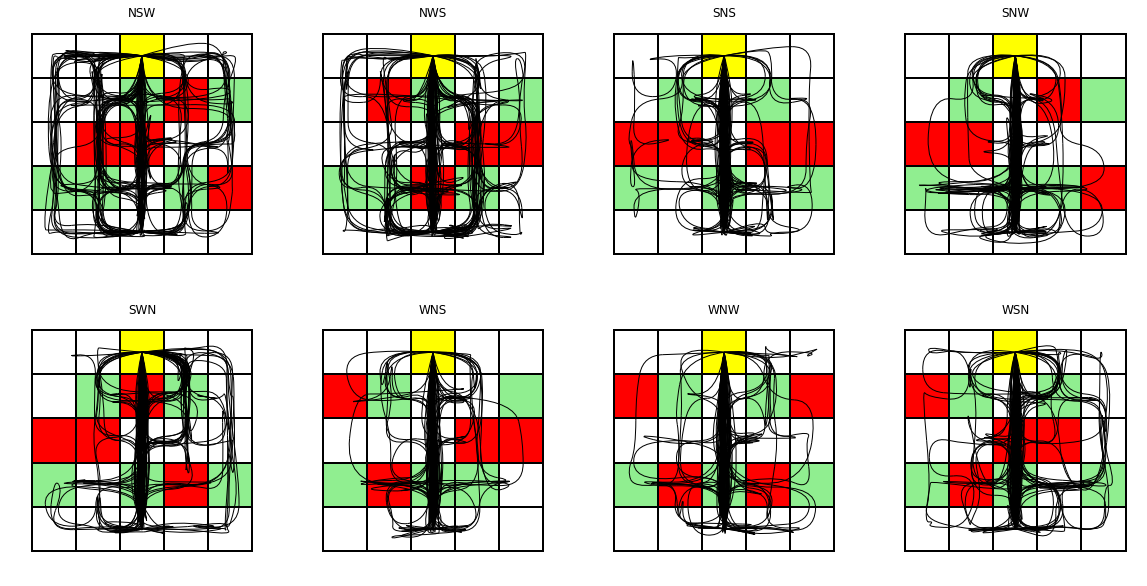

In [10]:
#visualize seed trajectories
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()
axi = 0
for grid, rows in grid_params.groupby(['grid']):
    gw = GridWorld(**rows.iloc[0]['params'])
    gwp = gw.plot(ax=axes[axi], feature_colors={'g':'lightgreen'})
    shuffle(seed_trajs[grid])
    for traj in seed_trajs[grid][:80]:
        gwp.plot_trajectory(traj[:-1])
    gwp.title("{}".format(grid))
    axi += 1

In [6]:
np.seterr(divide='ignore', under='ignore') #ignore division by zero and underflow

#===========================================#
#   Build Observer Belief MDP and support   #
#===========================================#

grid_obplanners = {}
for grid, gw_params in grid_params.groupby('grid'):
    grid_obplanners[grid] = {}
    ground_planners = grid_planners[grid]
    for _, prow in gw_params.iterrows(): 
        true_tf = prow['tf']
        obmdp = DiscretizedObserverBeliefMDPApproximation(
            n_probability_bins=n_bins,
            seed_trajs=seed_trajs[grid],
            branch_steps=0,
            discretized_tf=None,
            planners=ground_planners,
            true_planner_name=true_tf,
            belief_reward_type='true_gain',
            only_belief_reward=False,
            belief_reward=show_reward,
            update_includes_intention=True
        )
        obplanner = obmdp.solve(
            softmax_temp=show_temp,
            randchoose=show_randchoose,
            discount_rate=show_discount
        )
        grid_obplanners[grid][true_tf] = obplanner


#===========================================#
#   Observer Belief MDP with no intentions  #
#===========================================#
grid_obplanners_noint = {}
for grid, gw_params in grid_params.groupby('grid'):
    grid_obplanners_noint[grid] = {}
    ground_planners = grid_planners[grid]
    for _, prow in gw_params.iterrows(): 
        true_tf = prow['tf']
        obmdp = DiscretizedObserverBeliefMDPApproximation(
            n_probability_bins=n_bins,
            seed_trajs=seed_trajs[grid],
            branch_steps=0,
            discretized_tf=None,
            planners=ground_planners,
            true_planner_name=true_tf,
            belief_reward_type='true_gain',
            only_belief_reward=False,
            belief_reward=show_reward,
            update_includes_intention=False
        )
        obplanner = obmdp.solve(
            softmax_temp=show_temp,
            randchoose=show_randchoose,
            discount_rate=show_discount
        )
        grid_obplanners_noint[grid][true_tf] = obplanner

In [7]:
# Basic Second-order reasoning MDP
ob2_gridtf_mdps = {}
for (grid, tf), _ in grid_params.groupby(['grid', 'tf']):
    ob2_mdp = ObserverBeliefMDP(
        planners=grid_obplanners[grid],
        true_planner_name=tf,
        belief_reward_type='true_gain',
        only_belief_reward=False,
        belief_reward=show_reward,
        update_includes_intention=True
    )
    ob2_gridtf_mdps[grid] = ob2_gridtf_mdps.get(grid, {})
    ob2_gridtf_mdps[grid][tf] = ob2_mdp

In [8]:
#convert ground planners to nested ground planners (i.e., obmdp representation)
grid_planners_nested = {}
for (grid, tf), _ in grid_params.groupby(['grid', 'tf']):
    ob_mdp = DiscretizedObserverBeliefMDPApproximation(
        n_probability_bins=n_bins,
        seed_trajs=seed_trajs,
        branch_steps=0,
        discretized_tf=grid_obplanners[grid][tf].mdp.get_discretized_tf(),
        planners=grid_planners[grid],
        true_planner_name=tf,
        belief_reward_type='true_gain',
        only_belief_reward=False,
        belief_reward=0,
        update_includes_intention=True
    )
    ob_pl = ob_mdp.solve(
        softmax_temp=show_temp,
        randchoose=show_randchoose,
        discount_rate=show_discount
    )
    grid_planners_nested[grid] = grid_planners_nested.get(grid, {})
    grid_planners_nested[grid][tf] = ob_pl

In [9]:
# Joint Second-order reasoning
ob2j_gridtf_mdps = {}
for (grid, tf), _ in grid_params.groupby(['grid', 'tf']):
    joint_planners = {}
    joint_planners.update({tf+"_nocom": pl for tf, pl in grid_planners_nested[grid].items()})
    joint_planners.update({tf+"_com": pl for tf, pl in grid_obplanners[grid].items()})
    ob2j_mdp = ObserverBeliefMDP(
        planners=joint_planners,
        true_planner_name=tf+"_nocom",
        belief_reward_type='true_gain',
        only_belief_reward=False,
        belief_reward=show_reward,
        update_includes_intention=True
    )
    ob2j_gridtf_mdps[grid] = ob2j_gridtf_mdps.get(grid, {})
    ob2j_gridtf_mdps[grid][tf] = ob2j_mdp

# Trajectory Statistics

In [10]:
def is_jump(step, gw):
    s, a = step[0], step[1]
    tdist = gw.transition_dist(s=s, a=a)
    if len(tdist) > 1:
        return True
    return False

def is_risky_jump(step, gw):
    if not is_jump(step, gw):
        return None
    s, a = step[0], step[1]
    tdist = gw.transition_dist(s=s, a=a)
    p_ns = sorted([(p, s) for s, p in tdist.items()], reverse=True)
    ord_ns = [ns for p, ns in p_ns]
    if gw.state_features[ord_ns[0]] != 'x' and \
            gw.state_features[ord_ns[1]] == 'x':
        return True
    else:
        return False

def is_majority_jump(step, gw):
    if not is_jump(step, gw):
        return None
    s, a, ns = step[0], step[1], step[2]
    dist = abs(s[0] - ns[0]) + abs(s[1] - ns[1])
    return {"W": 1, "S": 2}[row['tf']] == dist

def calc_traj_stats(row):
    tdata = {}
    
    traj = row['traj']
    ob_pl = grid_obplanners[row['grid']][row['tf']]
    ob_mdp = ob_pl.mdp
    btraj = ob_mdp._wtraj_to_btraj(traj)
    tfs = ob_pl.mdp.planner_order
    final_b = dict(zip(["b."+tf for tf in tfs], btraj[-1][0][0]))
    final_b["b.target"] = final_b["b."+row["tf"]]
    tdata.update(final_b)
    
    ob2_mdp = ob2_gridtf_mdps[row['grid']][row['tf']]
    b2traj = ob2_mdp._wtraj_to_btraj(btraj)
    tfs = ob2_mdp.planner_order
    final_b2 = dict(zip(["b2."+tf for tf in tfs], b2traj[-1][0][0]))
    final_b2["b2.target"] = final_b2["b2."+row["tf"]]
    tdata.update(final_b2)
    
    ob2j_mdp = ob2j_gridtf_mdps[row['grid']][row['tf']]
    b2jtraj = ob2j_mdp._wtraj_to_btraj(btraj)
    tfs = ob2j_mdp.planner_order
    final_b2j = dict(zip(["b2j."+tf for tf in tfs], b2jtraj[-1][0][0]))
    final_b2j["b2j.target_com"] = final_b2j["b2j."+row["tf"]+"_com"]
    final_b2j["b2j.target_nocom"] = final_b2j["b2j."+row["tf"]+"_nocom"]
    final_b2j["b2j.target"] = final_b2j["b2j.target_com"] + final_b2j["b2j.target_nocom"]
    final_b2j["b2j.com"] = sum([final_b2j["b2j."+tf+"_com"] for tf in ["S", "W"]])
    tdata.update(final_b2j)
    
    gw = gridworlds[row['grid']][row['tf']]
    
    n_jumps = sum(filter(None, [is_jump(st, gw) for st in row['traj']]))
    n_risky_jumps = sum(filter(None, [is_risky_jump(st, gw) for st in row['traj']]))
    n_majority_jumps = sum(filter(None, [is_majority_jump(st, gw) for st in row['traj']]))
    n_steps = len(row['traj'])
    
    tdata.update({
        "n_jumps": n_jumps,
        "n_risky_jumps": n_risky_jumps,
        "n_majority_jumps": n_majority_jumps,
        "n_steps": n_steps,
        "risky_jumps_per_jump": n_risky_jumps/n_jumps if n_jumps > 0 else 0,
        "jumps_per_traj": n_jumps/n_steps,
        "maj_jumps_per_jump": n_majority_jumps/n_jumps if n_jumps > 0 else 0
    })
    
    return pd.Series(tdata)

# Simulations

In [11]:
# Simulate trajectories
n_trajs = 100
np.random.seed(4444)

sim_trajs = []
for grid in grid_planners.keys():
    for tf in grid_planners[grid].keys():
        pl = grid_planners[grid][tf]
        obpl = grid_obplanners[grid][tf]
        obpl_noint = grid_obplanners_noint[grid][tf]
        for traj_i in range(n_trajs):
            #do
            traj = pl.run()
            sim_trajs.append({
                'traj': traj,
                'i': traj_i,
                'cond': 'do',
                'grid': grid,
                'tf': tf
            })
            #show
            traj = obpl.run()
            traj = [(s[1], a, ns[1], r) for s, a, ns, r in traj][:-1]
            sim_trajs.append({
                'traj': traj,
                'i': traj_i,
                'cond': 'show',
                'grid': grid,
                'tf': tf
            })
            #show with no inverse planning model
            traj = obpl_noint.run()
            traj = [(s[1], a, ns[1], r) for s, a, ns, r in traj][:-1]
            sim_trajs.append({
                'traj': traj,
                'i': traj_i,
                'cond': 'show-noint',
                'grid': grid,
                'tf': tf
            })
sim_trajs = pd.DataFrame(sim_trajs)
sim_trajs = pd.concat([sim_trajs, sim_trajs.apply(calc_traj_stats, axis=1)],
                     axis=1)
sim_trajs.to_pickle("./_comps/sim-trajs.df.pkl")

In [16]:
sim_trajs.groupby(['cond', 'tf'])[['b.target', 'b2.target', 'b2j.target', 'b2j.com', 'n_steps', 'n_jumps', 'risky_jumps_per_jump']].\
    agg(["mean", "sem"])

b.target           b2.target           b2j.target            \
                   mean       sem      mean       sem       mean       sem   
cond       tf                                                                
do         S   0.703877  0.009256  0.741672  0.013558   0.722258  0.009593   
           W   0.724656  0.008538  0.809301  0.012474   0.720092  0.009039   
show       S   0.939205  0.003494  0.999178  0.000305   0.970953  0.002021   
           W   0.972757  0.001966  0.998710  0.001064   0.997096  0.001073   
show-noint S   0.809821  0.006913  0.880273  0.008954   0.843841  0.007050   
           W   0.789648  0.008234  0.880013  0.010380   0.791640  0.008644   

                b2j.com            n_steps            n_jumps            \
                   mean       sem     mean       sem     mean       sem   
cond       tf                                                             
do         S   0.199969  0.008597  6.17000  0.047807  1.05500  0.010874   
           W   0.154187  0.008433  6.72750  0.052063  0.96750  0.013068   
show       S   0.771551  0.009075  6.75250  0.078680  1.71375  0.047190   
           W   0.870733  0.007304  7.60750  0.060721  1.50875  0.031492   
show-noint S   0.393043  0.012487  6.83500  0.144703  2.27500  0.085599   
           W   0.299522  0.013480  7.06625  0.087871  1.63750  0.044660   

              risky_jumps_per_jump            
                              mean       sem  
cond       tf                                 
do         S              0.379896  0.016929  
           W              0.249583  0.015228  
show       S              0.573021  0.014009  
           W              0.388750  0.015941  
show-noint S              0.327707  0.014330  
           W              0.231722  0.014403

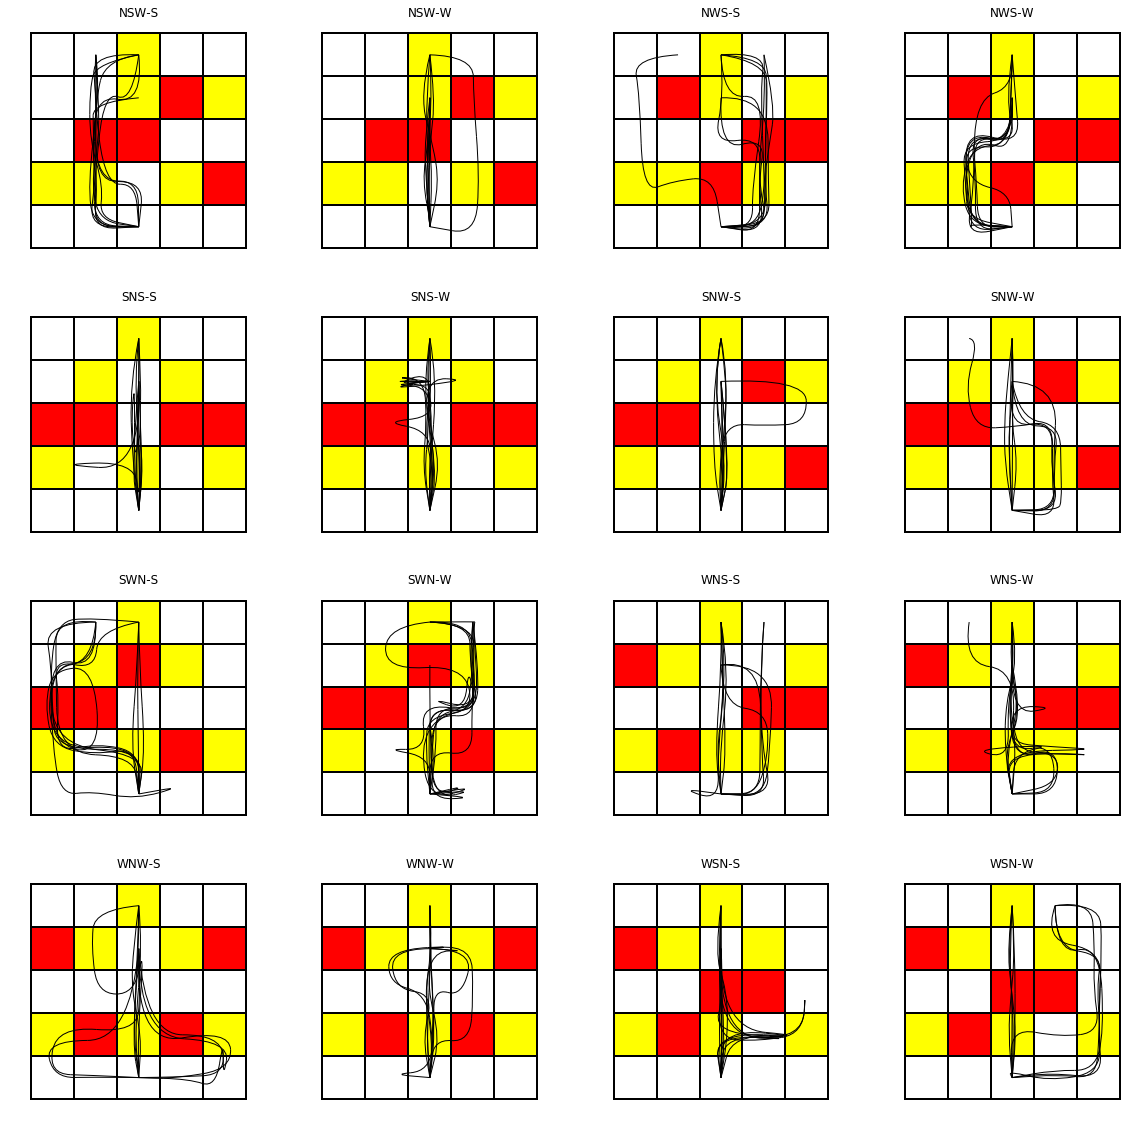

In [24]:
#visualize simulated trajectories
fig, axes = plt.subplots(4, 4, figsize=(20, 20))
axes = axes.flatten()
axi = 0
for (grid, tf), rows in sim_trajs.groupby(["grid", "tf"]):
    pl = grid_obplanners[grid][tf]
    gwp = pl.mdp.true_planner.mdp.plot(axes[axi])
    for traj in rows['traj'][:10]:
        gwp.plot_trajectory(traj[:-1])
    gwp.title("{}-{}".format(grid, tf))
    axi += 1

# Statistics on Experimental Trials

In [27]:
exp_trials = pd.read_pickle('../data/exp2-trials.pd.pkl')

In [28]:
def calc_trial_stats(row):
    gw = gridworlds[row['grid']][row['tf']]
    st = (row['stateaction'][0], row['stateaction'][1], row['next_state'])
    return pd.Series({
        "is_jump": is_jump(st, gw),
        "is_risky_jump": is_risky_jump(st, gw),
        "is_majority_jump": is_majority_jump(st, gw)
    })
exp_trials_stats = exp_trials[exp_trials['phase'] == 'main']
exp_trials_stats = pd.concat([exp_trials_stats,
                              exp_trials_stats.apply(calc_trial_stats, axis=1)],
                             axis=1)
exp_trials_stats.to_pickle("./_comps/exp-trials-stats.pd.pkl")

# Stats on Experimental Trajectories

In [29]:
def build_traj(trials):
    trials = trials.sort_values("timestep")
    traj = trials.apply(lambda r: (r["stateaction"][0], r["stateaction"][1], r["next_state"]),
                        axis=1)
    return list(traj)

exp_trajs = exp_trials[exp_trials['phase'] == 'main'].\
    groupby(["cond", "participant", "grid", "tf", "round"]).\
    apply(build_traj)

def test_valid_traj(row):
    gw = gridworlds[row['grid']][row['tf']]
    return gw.is_valid_trajectory(row["traj"])

exp_trajs = exp_trajs.reset_index(name="traj")
exp_trajs["is_valid"] = exp_trajs.apply(test_valid_traj, axis=1)

assert(exp_trajs['is_valid'].all())

exp_trajs = pd.concat([exp_trajs, exp_trajs.apply(calc_traj_stats, axis=1)],
                      axis=1)
exp_trajs.to_pickle("./_comps/exp-trajs.df.pkl")